In [3]:
import pandas as pd
import numpy as np

### Ajuste de hiperparametros y mejora de modelos

#### Uso de pipelines

In [4]:
df = pd.read_csv('https://bit.ly/3gob0mX', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [8]:
le.transform(['M', 'B'])

array([1, 0])

In [9]:
# Separar conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [10]:
# Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [11]:
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_hat = pipe_lr.predict(X_test)
print(f'Test Accuracy: {pipe_lr.score(X_test, y_test):.3f}')

Test Accuracy: 0.956


#### K-fold cross validation

In [12]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [13]:
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = [] # Evaluación de cada fold
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Fold: {k+1:2d}, Class dist.: {np.bincount(y_train[train])}, Acc: {score:.3f}')

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [14]:
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy: 0.950 +/- 0.014


In [15]:
# Cross validation con scikit-learn
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print(f'CV accuracy scores: {scores}')
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


#### Curvas de aprendizaje y de validación

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1, 10), cv=10, n_jobs=1)

In [17]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

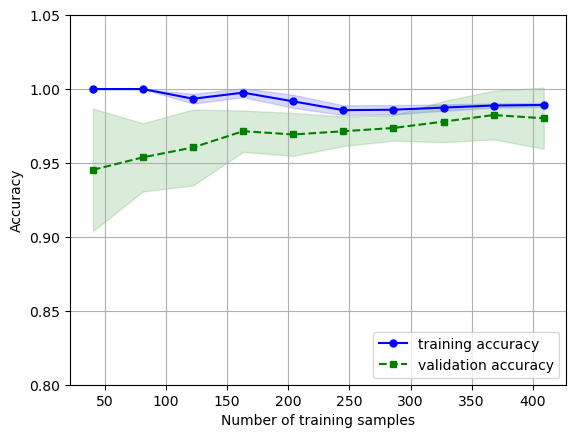

In [18]:
# Entrenamiento
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

# Pruebas
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

# Amenidades
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.05])
# plt.tight_layout()
plt.show()

Curva de validación: ajuste de hiperparametros

In [19]:
from sklearn.model_selection import validation_curve
param_range = [10**i for i in range(-3, 3)]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, param_name='logisticregression__C', param_range=param_range, cv=10, n_jobs=1)

In [20]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

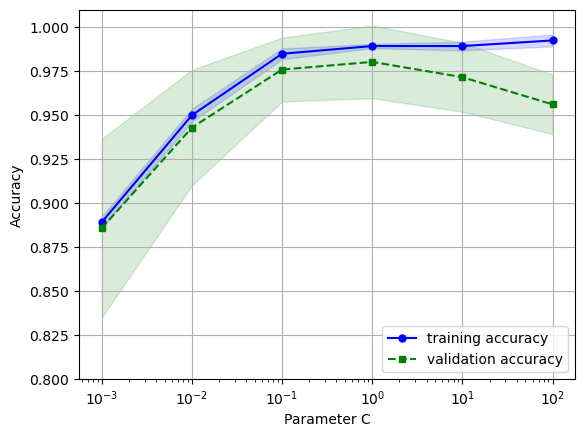

In [21]:
# Entrenamiento
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
# Pruebas
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
# Amenidades
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.01])
plt.show()

#### Ajuste de hiperparámetros con busqueda de malla

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [23]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [10**i for i in range(-4, 5)]
param_grid_svc = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid_svc, scoring='accuracy', cv=10, n_jobs=1)
gs = gs.fit(X_train, y_train)

In [24]:
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [25]:
# Exactitud del mejor estimador
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.974


#### Selección de algoritmos de validación cruzada anidada (NCV) - Cross Validation

In [26]:
gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid_svc, scoring = 'accuracy', cv=2)

scores = cross_val_score(gs, X_train, y_train, cv = 5, scoring = 'accuracy')

In [27]:
print('Exactitud NCV para SVC: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Exactitud NCV para SVC: 0.974 +/- 0.015


In [28]:
param_grid_lr = [{'logisticregression__C': param_range, 'logisticregression__solver': ['lbfgs', "linear","newton-cg", "newton-cholesky", "sag", "saga"]}]

gs = GridSearchCV(estimator = pipe_lr, param_grid = param_grid_lr, scoring = 'accuracy', cv=2,n_jobs=-1)
scores = cross_val_score(estimator = gs, X = X_train, y = y_train, cv = 5, scoring = "accuracy",n_jobs=-1) # -1 en n_jobs es para usar todos los nucleos

In [29]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 0),
                  param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring = 'accuracy', cv = 2)
scores = cross_val_score(estimator = gs, X = X_train, y = y_train, cv = 5, scoring = "accuracy",n_jobs=-1)

In [30]:
print('Exactitud NCV para DT: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Exactitud NCV para DT: 0.934 +/- 0.016


#### Matriz de confusión

In [31]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_hat = pipe_svc.predict(X_test)
conf_mat = confusion_matrix(y_true = y_test, y_pred = y_hat)
print(conf_mat)

[[71  1]
 [ 2 40]]


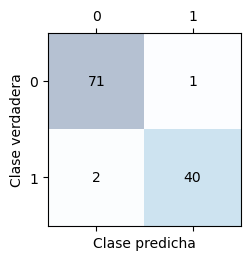

In [32]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(conf_mat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x = j, y = i, s = conf_mat[i, j], va = 'center', ha = 'center')
plt.xlabel('Clase predicha')
plt.ylabel('Clase verdadera')
plt.show()

# Me dice que tanto se equivoco mi predicción en comparación con los valores reales

# Lectura:
# 1. Es 0 y el modelo me dijo que es 0 = 71
# 2. Es 1 y el modelo me dijo que es 0 = 2  # Falso negativo
# 3. Es 0 y el modelo me dijo que es 1 = 1  # Falso positivo
# 4. Es 1 y el modelo me dijo que es 1 = 40

# Es decir, mis errores estan en la antidiagonal

### Metricas

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision: %.3f' % precision_score(y_true =y_test, y_pred = y_hat))
print('Sensitividad: %.3f' % recall_score(y_true =y_test, y_pred = y_hat))
print('F1: %.3f' % f1_score(y_true = y_test, y_pred = y_hat))
# Con esto nos damos cuenta que tenemos más falsos negativos que falsos positivos

Precision: 0.976
Sensitividad: 0.952
F1: 0.964


Creamos una métrica propia

In [34]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label = 0)
param_grid_svs = [{'svc__C': param_range, 'svc__kernel': ['linear']},
                  {'svc__C': param_range, 'svc__gamma':param_range, 'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid_svc, scoring = scorer, cv = 10, n_jobs = -1)

gs = gs.fit(X_train, y_train)

In [35]:
print(gs.best_score_)
print(gs.best_params_)

0.9880771478667446
{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


#### Curva ROC y area bajo la curva

In [36]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty='l2', C=100, random_state=1))
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

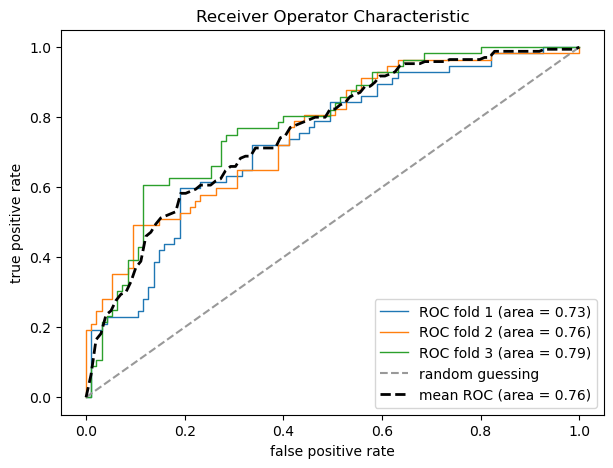

In [37]:
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'mean ROC (area = {mean_auc:.2f})', lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.show()

#### Datos desbalanceados

In [38]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [39]:
from sklearn.utils import resample
print('Número de muestras de la clase 1 antes:', X_imb[y_imb == 1].shape[0])

Número de muestras de la clase 1 antes: 40


In [40]:
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1], replace=True, n_samples=X_imb[y_imb == 0].shape[0], random_state=123)

print('Número de muestras de la clase 1 después:', X_upsampled.shape[0])

Número de muestras de la clase 1 después: 357


In [41]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0